# FISH image processing pipeline

## 1. Cellpose Segmentation

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.getcwd()))

In [2]:
from src.segmentation import CellposeSegmenter

In [3]:
# Initialize the CellposeSegmenter
segmenter = CellposeSegmenter(
    gpu=True,  # Set to False if you don't have GPU
    model_type='nuclei',
    diam_mean=19.0
)

Initializing denoise model...
Denoise model initialized
Initializing cellpose model...
Cellpose model initialized


In [4]:
# Check files in your folders
# Make sure to use relative paths from where your notebook is
results = segmenter.check_files_in_folder(
    input_folder="data/input",
    output_folder="data/output"
)

Checking input folder: data/input
Contents of input folder data/input:
- cropped_polygon_x3000_y12000_width800.tif
- cropped_polygon_x7247_y14117_width800.tif


In [ ]:
# It takes a while to process all the images
segmenter.process_images_in_folder("data/input", "data/output")

## 2. Get the reference line for stitching

In [1]:
from src.reference_line_analysis import *

In [2]:
# Input vertices from FIJI
# dataformat is (x, y, z)

vertices_3d = [
    (0.00, 0.00, 0.00),      # tile1
    (913.27, 5.24, 0.00),    # tile2
    (902.49, 920.44, 1.66),  # tile3
    (-16.66, 917.27, 2.32),  # tile4
    (-29.58, 1837.83, 3.75), # tile5
    (883.43, 1845.85, 5.24)  # tile6
]

In [3]:
# Package-level configurations
tile_zise = 1024
overlap_percentage = 10

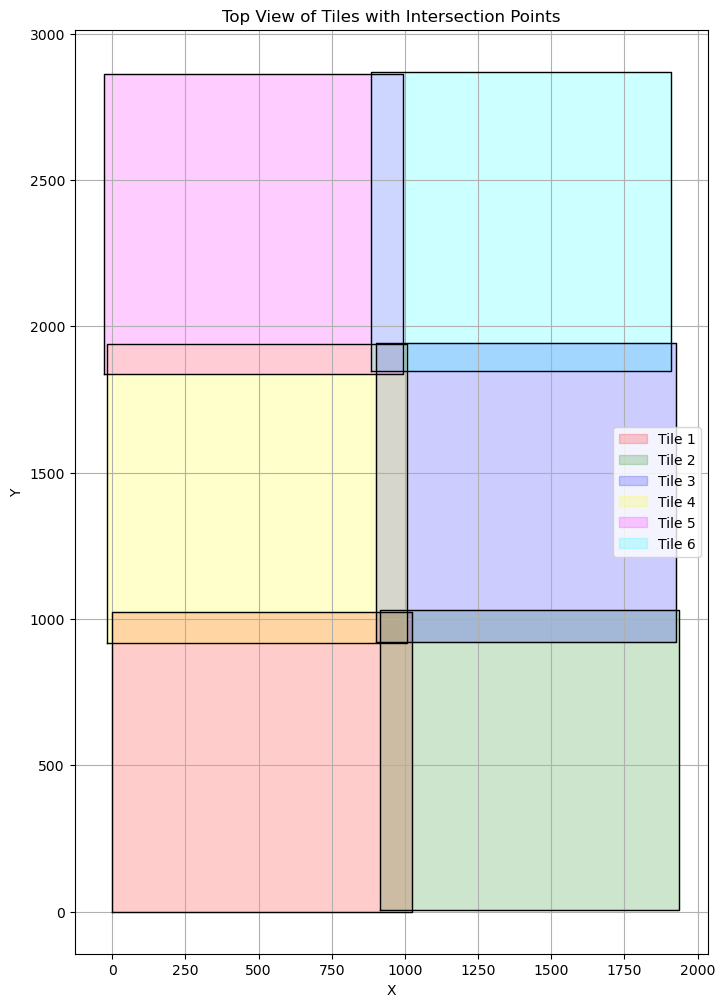

In [4]:
# Convert to 2D
vertices_2d = VertexConverter.convert_3d_to_2d(vertices_3d)
TilePlotter.plot_top_view(vertices_2d)

In [5]:
analyzer = TileAnalyzer(tile_size=1024)
x_coords, y_coords, intersections = analyzer.get_all_xy_coordinates(vertices_2d)
intersections

[{'x': 1024.0, 'y': 5.24, 'tiles': (1, 2)},
 {'x': 913.27, 'y': 1024.0, 'tiles': (1, 2)},
 {'x': 1024.0, 'y': 920.44, 'tiles': (1, 3)},
 {'x': 902.49, 'y': 1024.0, 'tiles': (1, 3)},
 {'x': 1007.34, 'y': 1024.0, 'tiles': (1, 4)},
 {'x': 0.0, 'y': 917.27, 'tiles': (1, 4)},
 {'x': 1926.49, 'y': 1029.24, 'tiles': (2, 3)},
 {'x': 913.27, 'y': 920.44, 'tiles': (2, 3)},
 {'x': 1007.34, 'y': 1029.24, 'tiles': (2, 4)},
 {'x': 913.27, 'y': 917.27, 'tiles': (2, 4)},
 {'x': 1007.34, 'y': 920.44, 'tiles': (3, 4)},
 {'x': 902.49, 'y': 1941.27, 'tiles': (3, 4)},
 {'x': 994.42, 'y': 1944.44, 'tiles': (3, 5)},
 {'x': 902.49, 'y': 1837.83, 'tiles': (3, 5)},
 {'x': 1907.4299999999998, 'y': 1944.44, 'tiles': (3, 6)},
 {'x': 902.49, 'y': 1845.85, 'tiles': (3, 6)},
 {'x': 994.42, 'y': 1941.27, 'tiles': (4, 5)},
 {'x': -16.66, 'y': 1837.83, 'tiles': (4, 5)},
 {'x': 1007.34, 'y': 1845.85, 'tiles': (4, 6)},
 {'x': 883.43, 'y': 1941.27, 'tiles': (4, 6)},
 {'x': 994.42, 'y': 1845.85, 'tiles': (5, 6)},
 {'x': 883

In [6]:
target_point = calculate_target_point(tile_zise, overlap_percentage)
target_point

(972.8, 972.8, 1945.6)

In [7]:
reference_points = find_AB_points(vertices_2d, target_point)
reference_points

{'x': {'point_A': 913.27, 'point_B': 994.42, 'middle_point': 953.845},
 'y1': {'point_A': 920.44, 'point_B': 1024.0, 'middle_point': 972.22},
 'y2': {'point_A': 1944.44, 'point_B': 2861.83, 'middle_point': 2403.135}}

## 3. Map back coordinates

In [8]:
from src.map_coordinates import *

In [9]:
tiles_number = 6

In [10]:
# Input vertices from FIJI
# dataformat is (x, y, z)

vertices_3d = [
    (0.00, 0.00, 0.00),      # tile1
    (913.27, 5.24, 0.00),    # tile2
    (902.49, 920.44, 1.66),  # tile3
    (-16.66, 917.27, 2.32),  # tile4
    (-29.58, 1837.83, 3.75), # tile5
    (883.43, 1845.85, 5.24)  # tile6
]

In [11]:
# Read all CSV files and get the dictionary of dataframes
folder_path='input/stitch'
outfolder_path='output/patch/Round1_coordinates_mapback_0114_centroids.csv'

dfs = read_csv_files(folder_path)

for df_name, df in dfs.items():
    globals()[df_name] = df

Successfully read: cp_masks_E3H5_Round1_DAPI_tile1_inference_centroids.csv -> pd_tile1
Successfully read: cp_masks_E3H5_Round1_DAPI_tile2_inference_centroids.csv -> pd_tile2
Successfully read: cp_masks_E3H5_Round1_DAPI_tile3_inference_centroids.csv -> pd_tile3
Successfully read: cp_masks_E3H5_Round1_DAPI_tile4_inference_centroids.csv -> pd_tile4
Successfully read: cp_masks_E3H5_Round1_DAPI_tile5_inference_centroids.csv -> pd_tile5
Successfully read: cp_masks_E3H5_Round1_DAPI_tile6_inference_centroids.csv -> pd_tile6


In [12]:
# Apply to all tiles with error checking
mapped_dfs = {}
for i in range(1, tiles_number+1):  
    df_name = f'pd_tile{i}'
    if df_name in dfs:  
        try:
            mapped_dfs[f'map_tile{i}'] = apply_offset_to_tile(dfs[df_name], i, vertices_3d)
            print(f"Successfully mapped {df_name} to map_tile{i}")
            print(f"Number of points in map_tile{i}: {len(mapped_dfs[f'map_tile{i}'])}")
        except Exception as e:
            print(f"Error mapping {df_name}: {str(e)}")
    else:
        print(f"Warning: {df_name} not found in dataframes")

# Verify all mapped tiles
print("\nMapped tiles available:", list(mapped_dfs.keys()))

Offset applied to tile 1: x+0.0, y+0.0, z+0.0
Successfully mapped pd_tile1 to map_tile1
Number of points in map_tile1: 45931
Offset applied to tile 2: x+913.27, y+5.24, z+0.0
Successfully mapped pd_tile2 to map_tile2
Number of points in map_tile2: 21673
Offset applied to tile 3: x+902.49, y+920.44, z+1.66
Successfully mapped pd_tile3 to map_tile3
Number of points in map_tile3: 26754
Offset applied to tile 4: x+-16.66, y+917.27, z+2.32
Successfully mapped pd_tile4 to map_tile4
Number of points in map_tile4: 42789
Offset applied to tile 5: x+-29.58, y+1837.83, z+3.75
Successfully mapped pd_tile5 to map_tile5
Number of points in map_tile5: 32396
Offset applied to tile 6: x+883.43, y+1845.85, z+5.24
Successfully mapped pd_tile6 to map_tile6
Number of points in map_tile6: 12475

Mapped tiles available: ['map_tile1', 'map_tile2', 'map_tile3', 'map_tile4', 'map_tile5', 'map_tile6']


In [13]:

for name, df in mapped_dfs.items():
    globals()[name] = df

In [14]:
# x_middle = reference_points['x']['middle_point']      # 953.845
# y1_middle = reference_points['y1']['middle_point']    # 972.22
# # y2_middle = reference_points['y2']['middle_point']    # 2403.135
x_middle = 953.845
y1_middle = 972.22
y2_middle = 1900

In [15]:
# Create sub-maps
map_tiles_6 = [map_tile1, map_tile2, map_tile3, map_tile4, map_tile5, map_tile6]
sub_mapped_dfs = create_sub_maps_for6(map_tiles_6, x_middle, y1_middle, y2_middle)

# Verify each sub-map
for tile_num in range(1, tiles_number+1):
    # Get the dataframe from the dictionary
    df = sub_mapped_dfs[f'sub_map_tile{tile_num}']
    
    print(f"\nVerifying sub_map_tile{tile_num}:")
    print(f"X range (centroid-1): {df['centroid-1'].min():.2f} to {df['centroid-1'].max():.2f}")
    print(f"Y range (centroid-2): {df['centroid-2'].min():.2f} to {df['centroid-2'].max():.2f}")
    print(f"Number of points: {len(df)}")

sub_map_tile1: 41011 points
sub_map_tile2: 18070 points
sub_map_tile3: 21992 points
sub_map_tile4: 36312 points
sub_map_tile5: 29834 points
sub_map_tile6: 8561 points

Verifying sub_map_tile1:
X range (centroid-1): 0.18 to 972.22
Y range (centroid-2): 0.13 to 953.83
Number of points: 41011

Verifying sub_map_tile2:
X range (centroid-1): 6.07 to 972.21
Y range (centroid-2): 953.87 to 1682.59
Number of points: 18070

Verifying sub_map_tile3:
X range (centroid-1): 972.24 to 1899.94
Y range (centroid-2): 953.93 to 1740.94
Number of points: 21992

Verifying sub_map_tile4:
X range (centroid-1): 972.25 to 1900.00
Y range (centroid-2): -16.54 to 953.79
Number of points: 36312

Verifying sub_map_tile5:
X range (centroid-1): 1900.05 to 2860.01
Y range (centroid-2): -29.42 to 953.78
Number of points: 29834

Verifying sub_map_tile6:
X range (centroid-1): 1900.01 to 2867.75
Y range (centroid-2): 953.85 to 1592.48
Number of points: 8561


In [16]:
for name, df in sub_mapped_dfs.items():
    globals()[name] = df

In [18]:
# Concatenate all sub-mapped tiles
all_points6 = pd.concat([sub_map_tile1, sub_map_tile2, sub_map_tile3, 
                       sub_map_tile4, sub_map_tile5, sub_map_tile6], 
                      ignore_index=True)

print(f"Total number of points after concatenation: {len(all_points6)}")


Total number of points after concatenation: 155780


In [20]:
# Concatenate all sub-mapped tiles
all_points4 = pd.concat([sub_map_tile1, sub_map_tile2, sub_map_tile3, 
                       sub_map_tile4], 
                      ignore_index=True)

print(f"Total number of points after concatenation: {len(all_points4)}")

Total number of points after concatenation: 117385


In [21]:
sub_df6 = all_points6[['centroid-2', 'centroid-1', 'centroid-0']]

In [ ]:
sub_df4 = all_points4[['centroid-2', 'centroid-1', 'centroid-0']]

In [22]:
non0_offset = find_lowest_negative(vertices_3d)

In [24]:
sub_df_move = sub_df6
# sub_df_move = sub_df4
sub_df_move[['centroid-2', 'centroid-1', 'centroid-0']] = sub_df_move[['centroid-2', 'centroid-1', 'centroid-0']] + non0_offset

C:\Users\Alexis\AppData\Local\Temp\ipykernel_71848\2344202723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_move[['centroid-2', 'centroid-1', 'centroid-0']] = sub_df_move[['centroid-2', 'centroid-1', 'centroid-0']] + non0_offset


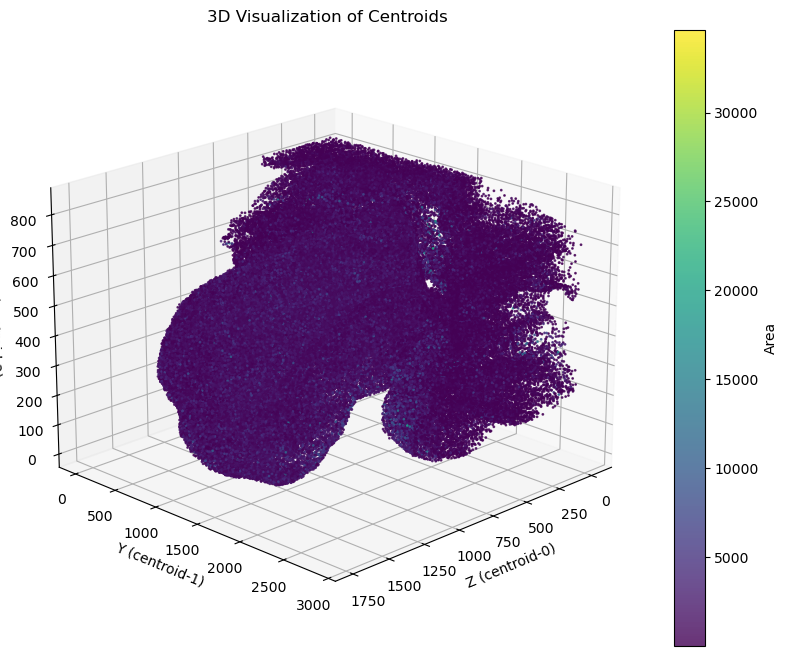

In [25]:
# Create and show the plot
fig = plot_3d_points(all_points6)
plt.show()  

In [27]:
sub_df_move.to_csv(outfolder_path, index=False, header=False)
print("Sub-map saved to:", outfolder_path)

Sub-map saved to: output/patch/Round1_coordinates_mapback_0114_centroids.csv
